In [1]:
import pandas as pd
pd.options.display.max_columns=50
from scipy import stats as st
import numpy as np
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import glob
from matplotlib import gridspec
import json
import os

### Read general metadata

In [7]:
df_meta= pd.read_csv("../../data/SuppTable1_sample_metadata - metadata.tsv",sep="\t")

### Read results from invididual analyses (coding mutation, cnv and non-coding mutation drivers)

In [8]:
coding= pd.read_csv("../data/coding_results_resistance.tsv.gz",sep="\t")
coding["significant"] = coding["qvalue"] <0.05
non_coding= pd.read_csv("../data/non_coding_results_resistance.tsv.gz",sep="\t")
non_coding["significant"] = non_coding["qvalue"] <0.1
cnv = pd.read_csv("../data/cnv_results_resistance.tsv.gz",sep="\t")
cnv["significant"] = cnv.apply(lambda r: r["qvalue"] <0.05 and r["not_gene"]==False,axis=1)
total = pd.concat([coding,non_coding,cnv])
total["label_spaces"] = total.apply(lambda row: row["label"].replace("_"," "),axis=1)
total["significant"]  = total.apply(lambda row: row["significant"] and row["log_odds_ratio"] >0.0,axis=1)
total["is_cancer_subtype"] = total.apply(lambda row: "_" in row["cancer_type_code"],axis=1)


In [9]:
dict_colors={'coding mutations':"#33a02c", 'non-coding mutation':"#b2df8a", 'Amp':"#e31a1c", 'Del':'#377eb8'}
dict_labels={'coding mutations':"Coding mutations", 'non-coding mutation':"Non-coding mutations", 'Amp':"CNV (high-level amplification)", 'Del':'CNV (homozygous deletion)'}

### Harmonize the counts of treated and untreated group samples (eg, the non-coding drivers removed hypermuted samples for the analysis)

In [10]:
d_total={}
for ff in  glob.glob("/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/dndscv/*/*.json"):
    drug = os.path.basename(ff).split(".")[0]
    ttype = os.path.dirname(ff).split("/")[-1]
    d_total[(drug,ttype)]=len(json.load(open(ff)))
total["freq_t"] = total.apply(lambda row: row["mutated_t"] / d_total[row["drug"],row["cancer_type_code"]],axis=1)
total["freq_c"] = total.apply(lambda row: row["mutated_c"] / d_total["untreated",row["cancer_type_code"]],axis=1)
total["exclusive"] = total["freq_c"] < 0.05

### Complement information of TEDs, and prepare dataset to be exported

In [11]:
total["is_TED"]=total.apply(lambda r: (r["significant"])&((r["representative_mech"])|(r["annotated"])),axis=1)
selected = total.merge(df_meta[["cancer_type_code","cancer_type"]].drop_duplicates(),how="left")
selected["proximal_cancer_genes"] = selected.apply(lambda row: str(row["drug_cancer_gene"]).split("::")[-1].replace(")","").replace("nan",""),axis=1)
selected=selected[["cancer_type","cancer_type_code","drug","gene","proximal_cancer_genes","label_spaces","type_alt","genomic_element","mutated_t","freq_t","mutated_c","freq_c","qvalue","log_qvalue","log_odds_ratio","significant","annotated","representative_mech","exclusive","is_TED"]].rename(columns={"mutated_t":"samples_mut_treatment","mutated_c":"samples_mut_control","exclusive":"is_treatment_exclusive","drug_cancer_gene":"proximal cancer gene","log_odds_ratio":"log2(odds_ratio)","label_spaces":"label"})
selected["samples_mut_control"] = selected["samples_mut_control"].astype(int)
selected["samples_mut_treatment"] = selected["samples_mut_treatment"].astype(int)
# Literature support
evidence_literature = pd.read_csv("../data/SuppTable8_TEDs - Orthogonal evidence TEDs.tsv",sep="\t").rename(columns={"cancertype":"cancer_type_code"})
selected = selected.merge(evidence_literature,how="left")

### Volcano plot (Figure 5)

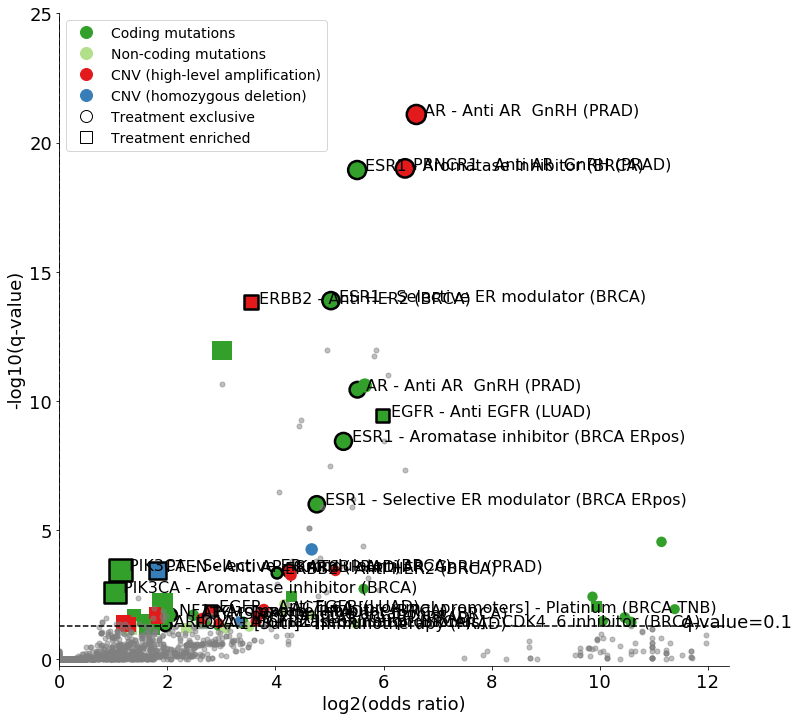

In [12]:
q=selected[selected["is_TED"]]
q1=selected[~selected["is_TED"]]
fig,ax=plt.subplots(figsize=(12,12))

q_e = q[q["is_treatment_exclusive"]]
q_ne = q[~q["is_treatment_exclusive"]]


ax.scatter(y=q_e.log_qvalue,x=q_e["log2(odds_ratio)"].values,color=[dict_colors[x] for x in q_e.type_alt],s=q_e["samples_mut_treatment"]**1.15+100,alpha=1.0,lw=[(r==True)*2.5 for r in q_e["annotated"]],edgecolor="black",marker="o")
ax.scatter(y=q_ne.log_qvalue,x=q_ne["log2(odds_ratio)"].values,color=[dict_colors[x] for x in q_ne.type_alt],s=q_ne["samples_mut_treatment"]**1.15+100,alpha=1.0,lw=[(r==True)*2.5 for r in q_ne["annotated"]],edgecolor="black",marker="s")


ax.scatter(y=q1.log_qvalue,x=q1["log2(odds_ratio)"].values,color="grey",s=25,alpha=0.5,marker="o")

ax.axhline(y=-np.log10(0.05),ls="--",color="black")
ax.axvline(x=0.0,ls="--",color="black"
          )
for i,r in q[q["Literature"].str.contains("10",na=False)].iterrows():
    ax.annotate(xy=(r["log2(odds_ratio)"]+0.15,r["log_qvalue"]),s=r["label"],fontsize=16)
maxv=np.nanmax([1,np.nanmax(q["log2(odds_ratio)"])])+1
ax.set_xlim(0,maxv)
ax.set_ylim(-0.25,25)
#ax.set_title("Representative cancer type specific resistance drivers, non-coding mutations",fontsize=14)
ax.set_ylabel("-log10(q-value)",fontsize=18)
ax.set_xlabel("log2(odds ratio)",fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.annotate(xy=(11.5,-np.log10(0.1)+0.25),s="q-value=0.1",fontsize=18)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in dict_colors.values()]+[plt.Line2D([0,0],[0,0],color="white", marker='o', linestyle='',lw=2,markeredgecolor="black"),plt.Line2D([0,0],[0,0],color="white", marker='s', linestyle='',lw=2,markeredgecolor="black")]
ax.legend(markers, [dict_labels[k] for k in dict_colors.keys()]+["Treatment exclusive","Treatment enriched"], numpoints=1,fontsize=14,loc="upper left",markerscale=2)
plt.savefig(f'../results/figures/volcano_plot_summary.pdf', dpi=800,bbox_inches="tight")

### Plot withouth labels

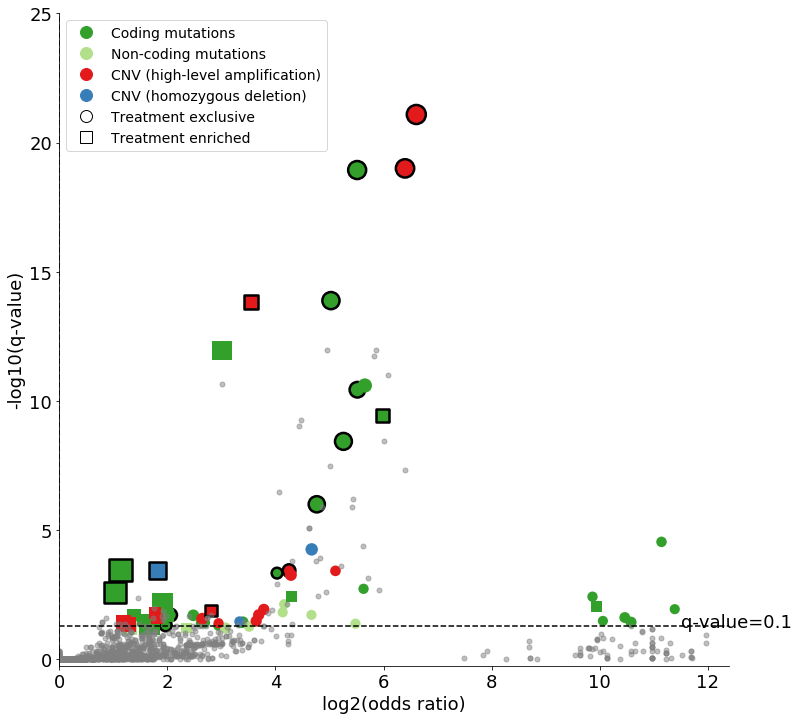

In [13]:
q=selected[selected["is_TED"]]
q1=selected[~selected["is_TED"]]
fig,ax=plt.subplots(figsize=(12,12))

q_e = q[q["is_treatment_exclusive"]]
q_ne = q[~q["is_treatment_exclusive"]]


ax.scatter(y=q_e.log_qvalue,x=q_e["log2(odds_ratio)"].values,color=[dict_colors[x] for x in q_e.type_alt],s=q_e["samples_mut_treatment"]**1.15+100,alpha=1.0,lw=[(r==True)*2.5 for r in q_e["annotated"]],edgecolor="black",marker="o")
ax.scatter(y=q_ne.log_qvalue,x=q_ne["log2(odds_ratio)"].values,color=[dict_colors[x] for x in q_ne.type_alt],s=q_ne["samples_mut_treatment"]**1.15+100,alpha=1.0,lw=[(r==True)*2.5 for r in q_ne["annotated"]],edgecolor="black",marker="s")


ax.scatter(y=q1.log_qvalue,x=q1["log2(odds_ratio)"].values,color="grey",s=25,alpha=0.5,marker="o")

ax.axhline(y=-np.log10(0.05),ls="--",color="black")
ax.axvline(x=0.0,ls="--",color="black"
          )

maxv=np.nanmax([1,np.nanmax(q["log2(odds_ratio)"])])+1
ax.set_xlim(0,maxv)
ax.set_ylim(-0.25,25)
#ax.set_title("Representative cancer type specific resistance drivers, non-coding mutations",fontsize=14)
ax.set_ylabel("-log10(q-value)",fontsize=18)
ax.set_xlabel("log2(odds ratio)",fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.annotate(xy=(11.5,-np.log10(0.1)+0.25),s="q-value=0.1",fontsize=18)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in dict_colors.values()]+[plt.Line2D([0,0],[0,0],color="white", marker='o', linestyle='',lw=2,markeredgecolor="black"),plt.Line2D([0,0],[0,0],color="white", marker='s', linestyle='',lw=2,markeredgecolor="black")]
ax.legend(markers, [dict_labels[k] for k in dict_colors.keys()]+["Treatment exclusive","Treatment enriched"], numpoints=1,fontsize=14,loc="upper left",markerscale=2)
plt.savefig(f'../results/figures/volcano_plot_summary_nolabels.pdf', dpi=800,bbox_inches="tight")

### Annotate subtype info and target treatment info

In [14]:
x={"BRCA_ERpos":"Breast cancer ER+/HER2-","BRCA_TNB":"Breast cancer triple negative","BRCA_HER2pos":"Breast cancer ER+/HER2+",
   "LUSC":"Lung squamous cell carcinoma","LUAD":"Lung adenocarcima","COREAD_MSS":"Colorectal cancer MSS","COREAD_MSI_POLE":"Colorectal cancer MSI"}

In [15]:
selected["is_subtype"] = selected["cancer_type_code"].str.contains("_")
selected["cancer_type"] = selected.apply(lambda r: x[r["cancer_type_code"]]  if  r["is_subtype"] else r["cancer_type"],axis=1)
subtypes=selected[selected["is_subtype"]==True]
subtypes["cancer_type_code"] = subtypes.apply(lambda row: row["cancer_type_code"].split("_")[0],axis=1)
subtypes["found_in_subtype"] = True
x1=subtypes[(subtypes["significant"]==True)&(subtypes["log2(odds_ratio)"]>0.0)][["found_in_subtype","cancer_type_code","drug","gene","type_alt"]].drop_duplicates()
x2=subtypes[(subtypes["significant"]==True)&(subtypes["log2(odds_ratio)"]>0.0)][["found_in_subtype","cancer_type_code","drug","proximal_cancer_genes","type_alt"]].drop_duplicates()
selected=selected.merge(x1,how="left").fillna({"found_in_subtype":False})
selected=selected.merge(x2,how="left",left_on=["cancer_type_code","drug","proximal_cancer_genes","type_alt"],right_on=["cancer_type_code","drug","proximal_cancer_genes","type_alt"]).fillna({"found_in_subtype_y":False})
selected["found_in_subtype"] = selected.apply(lambda r: r["found_in_subtype_x"]==True or r["found_in_subtype_y"]==True,axis=1)
selected.drop(["found_in_subtype_x","found_in_subtype_y"],axis=1,inplace=True)
# annotate whether is a target of treatment
targets = {("BRAF_inhibitor","BRAF"):True,("Anti_HER2","ERBB2"):True,("Anti_EGFR","EGFR"):True }
selected["is_target_treatment"] = selected.apply(lambda row:  (row["drug"],row["gene"]) in targets,axis=1)
selected.sort_values(["is_TED","qvalue"],ascending=[False,True]).to_csv("../results/data/table_all_TEDS.tsv",sep="\t",index=False)

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
selected[(selected["is_TED"]==True)].shape

(61, 25)

In [13]:
q=selected[(selected["is_TED"]==True)]

In [14]:
q["annotated"].value_counts()

False    44
True     17
Name: annotated, dtype: int64

In [15]:
q[["gene","cancer_type_code"]].drop_duplicates().shape

(52, 2)

In [16]:
q[["drug","cancer_type_code"]].drop_duplicates().shape

(33, 2)

In [17]:
q[["cancer_type_code"]].drop_duplicates().shape

(13, 1)

In [18]:
q[["drug"]].drop_duplicates().shape

(19, 1)

In [19]:
len(q["gene"].unique())

44

In [20]:
q["type_alt"].value_counts()

coding mutations       33
Amp                    16
non-coding mutation     9
Del                     3
Name: type_alt, dtype: int64

In [21]:
q[q["Literature"].str.contains("10",na=False)].shape

(23, 25)

In [22]:
23/61

0.3770491803278688

### TEDs side to side frequency visualization (non-exclusive), Extended Data Figure 9

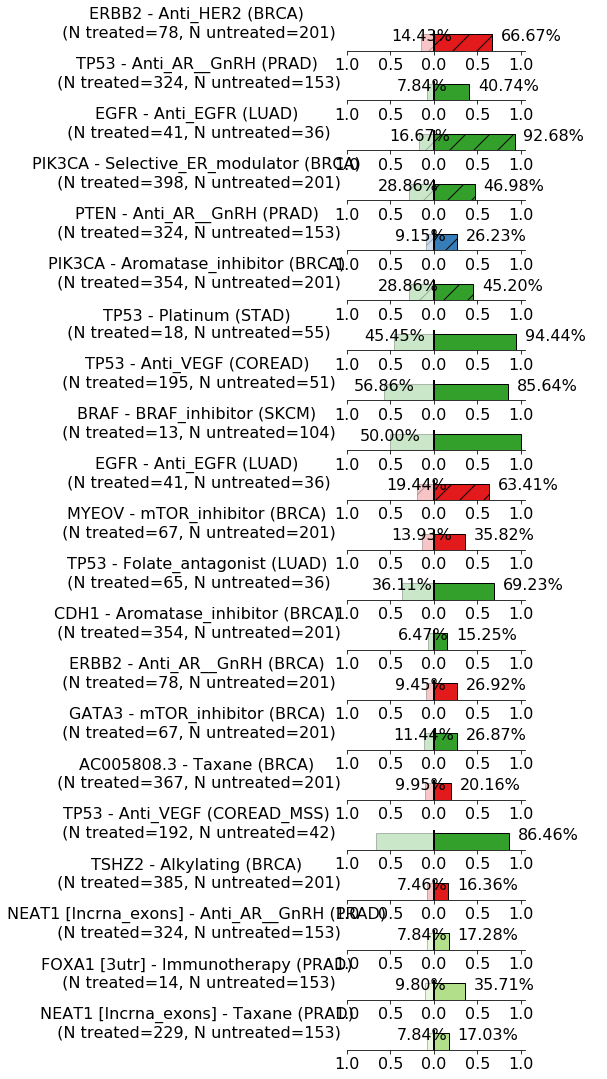

In [23]:
q=total[(total["significant"]==True)&((total["representative_mech"])|(total["annotated"]))&(~total["exclusive"])&(total["log_odds_ratio"]>0)]
n_examples=q.shape[0]
fig,ax = plt.subplots(figsize=(3.2,3+0.75*n_examples))

gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=n_examples)
gs.update(hspace=1.5, wspace=0.0)
j=0
dict_labels={'coding mutations':"Coding mutations", 'non-coding mutation':"Non-coding mutations", 'Amp':"CNV (high-level amplification)", 'Del':'CNV (homozygous deletion)'}
for i,row in q.sort_values("qvalue").iterrows():
    ax = plt.subplot(gs[j])
    dict_colors={'coding mutations':"#33a02c", 'non-coding mutation':"#b2df8a", 'Amp':"#e31a1c", 'Del':'#377eb8'}
    muts_t = row["mutated_t"] 
    total_t= d_total[(row["drug"],row["cancer_type_code"])]
    muts_c = row["mutated_c"] 
    total_c= d_total[("untreated",row["cancer_type_code"])]
    cat=row["type_alt"]
    hatch=""
    if row["annotated"]:
        hatch="/"
    m="c"
    if row["exclusive"]:
        m="s"
    ratio_t=muts_t / total_t
    ratio_c=muts_c / total_c
    ax.barh(y=0,width=ratio_t,color=dict_colors[cat],lw=1,edgecolor="black",hatch=hatch)
    
    ax.barh(y=0,width=-ratio_c,color=dict_colors[cat],lw=1,edgecolor="black",hatch=hatch,alpha=0.25)
    # annotate genes
    ax.annotate(xy=(ratio_t+0.1,0.2),s=format(ratio_t*100, ".2f")+"%",fontsize=16)
    ax.annotate(xy=(-ratio_c-0.35,0.2),s=format(ratio_c*100, ".2f")+"%",fontsize=16)
    
    
    #ax.annotate(xy=(0.3,0.7),s=f"N ={total_t}",fontsize=12)
    #ax.annotate(xy=(-1.0,0.7),s=f"N ={total_c}",fontsize=12)
    
    #ax.annotate(xy=(total_na_+total_an+0.05,i+1),s=format((total_na_+total_an)*100, ".2f")+"%",fontsize=14)
    #ax.annotate(xy=(-total_an_control-total_na_-0.5,i+1),s=format((total_an_control+total_na_control)*100, ".2f")+"% ",fontsize=14)
    ax.set_xlim(-1.0,1.05)
    ax.set_ylim(-0.1,0.5)
    ax.set_yticks([])
    
    ax.set_ylabel(row["label"]+f"\n (N treated={total_t}, N untreated={total_c})",fontsize=16,rotation=0,labelpad=+150)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([x/100.0 for x in range(-100,120,50)])
    ax.set_xticklabels([np.abs(x) for x in ax.get_xticks()],rotation=0)
    ax.tick_params(axis='x', which='major', labelsize=16)

    
    #ax.set_title(f"Resistance to {d.replace('_',' ')} in {t} \n (N untreated={len(d_untreated[t])}) (N treated={len(samples)})",fontsize=14)
    ax.axvline(x=0.0,lw=2,color="black")
    #ax.set_xticks([])
    j+=1

plt.savefig(f'../results/figures/resistance_by_treatment_detail_non_exclusive.pdf', dpi=800,bbox_inches="tight")

### TEDs side to side frequency visualization (exclusive), Extended Data Figure 9

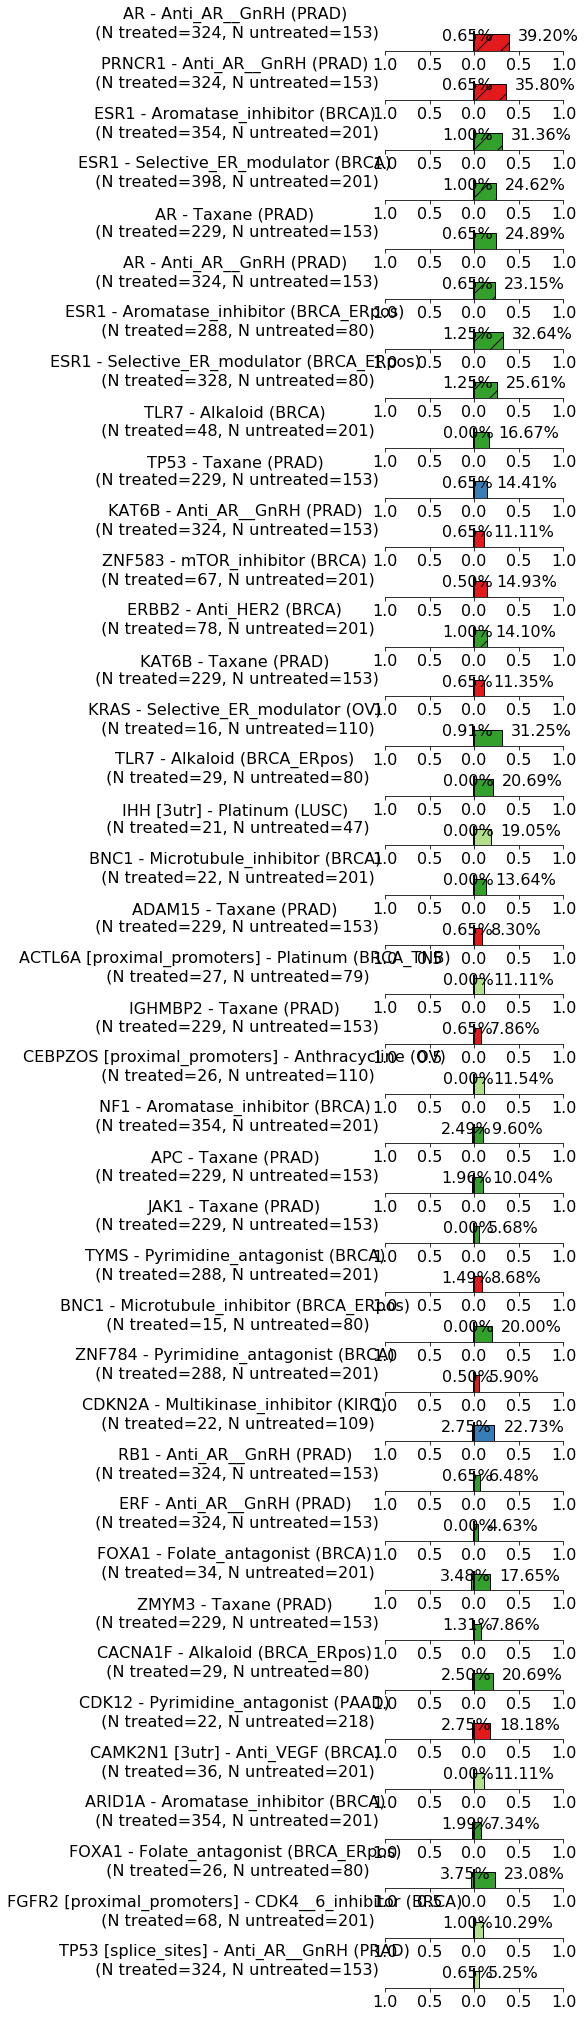

In [20]:
q=total[(total["significant"])&((total["representative_mech"])|(total["annotated"]))&(total["exclusive"])&(total["log_odds_ratio"]>0)]
n_examples=q.shape[0]
fig,ax = plt.subplots(figsize=(3.2,6+0.75*n_examples))

gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=n_examples)
gs.update(hspace=1.5, wspace=0.0)
j=0
dict_labels={'coding mutations':"Coding mutations", 'non-coding mutation':"Non-coding mutations", 'Amp':"CNV (high-level amplification)", 'Del':'CNV (homozygous deletion)'}
for i,row in q.sort_values("qvalue").iterrows():
    ax = plt.subplot(gs[j])
    dict_colors={'coding mutations':"#33a02c", 'non-coding mutation':"#b2df8a", 'Amp':"#e31a1c", 'Del':'#377eb8'}
    muts_t = row["mutated_t"] 
    total_t= d_total[(row["drug"],row["cancer_type_code"])]
    muts_c = row["mutated_c"] 
    total_c= d_total[("untreated",row["cancer_type_code"])]
    cat=row["type_alt"]
    hatch=""
    if row["annotated"]:
        hatch="/"
    m="c"
    if row["exclusive"]:
        m="s"
    ratio_t=muts_t / total_t
    ratio_c=muts_c / total_c
    ax.barh(y=0,width=ratio_t,color=dict_colors[cat],lw=1,edgecolor="black",hatch=hatch)
    
    ax.barh(y=0,width=-ratio_c,color=dict_colors[cat],lw=1,edgecolor="black",hatch=hatch)
    # annotate genes
    ax.annotate(xy=(ratio_t+0.1,0.2),s=format(ratio_t*100, ".2f")+"%",fontsize=16)
    ax.annotate(xy=(-ratio_c-0.35,0.2),s=format(ratio_c*100, ".2f")+"%",fontsize=16)
    
    
    ax.annotate(xy=(0.3,0.7),s=f"N ={total_t}",fontsize=16)
    ax.annotate(xy=(-1.0,0.7),s=f"N ={total_c}",fontsize=16)
    
    #ax.annotate(xy=(total_na_+total_an+0.05,i+1),s=format((total_na_+total_an)*100, ".2f")+"%",fontsize=14)
    #ax.annotate(xy=(-total_an_control-total_na_-0.5,i+1),s=format((total_an_control+total_na_control)*100, ".2f")+"% ",fontsize=14)
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-0.1,0.5)
    ax.set_yticks([])
    
    ax.set_ylabel(row["label"]+f"\n (N treated={total_t}, N untreated={total_c})",fontsize=16,rotation=0,labelpad=+150)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([x/100.0 for x in range(-100,120,50)])
    ax.set_xticklabels([np.abs(x) for x in ax.get_xticks()],rotation=0)
    ax.tick_params(axis='x', which='major', labelsize=16)

    
    #ax.set_title(f"Resistance to {d.replace('_',' ')} in {t} \n (N untreated={len(d_untreated[t])}) (N treated={len(samples)})",fontsize=14)
    ax.axvline(x=0.0,lw=2,color="black")
    #ax.set_xticks([])
    j+=1

plt.savefig(f'../results/figures/resistance_by_treatment_detail_exclusive.pdf', dpi=800,bbox_inches="tight")